In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split


# 数据加载

In [3]:
train_0 = pd.read_csv('train.csv',names=['A','B','C','D','E','F','G','H','I','J','K','L','M','Y'])
test_0 = pd.read_csv('test.csv',names=['A','B','C','D','E','F','G','H','I','J','K','L','M'])

In [4]:
train_0.shape

(7194, 14)

# 缺失值处理和填补

## 删除缺失值大于三个的行

In [5]:
train_0 = train_0[(train_0 == '?').sum(axis=1) < 3]

In [6]:
train_0.shape

(7114, 14)

## 查看列的缺失值数量

In [7]:
(train_0 == '?').sum(axis=0)

A      0
B     97
C      0
D     57
E    101
F    672
G      0
H    242
I      0
J    143
K    232
L     44
M    253
Y      0
dtype: int64

由此可知F缺失值过多，不建议选择

In [8]:
train_0.replace('?',np.nan,inplace=True)
imp_0 = Imputer(missing_values=np.nan,strategy='mean')
imp_0.fit(train_0)
train = pd.DataFrame(imp_0.transform(train_0),columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','Y'])

In [9]:
test_0.replace('?',np.nan,inplace=True)
imp_1 = Imputer(missing_values=np.nan,strategy='mean')
imp_1.fit(test_0)
test = pd.DataFrame(imp_1.transform(test_0),columns=['A','B','C','D','E','F','G','H','I','J','K','L','M'])

# 画图分析

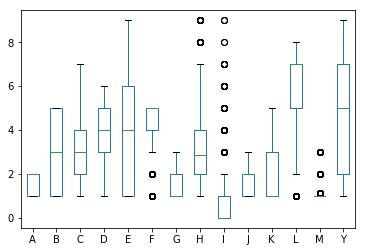

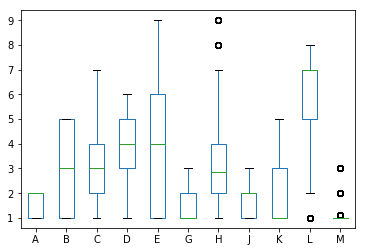

In [10]:
train.plot(kind='box')
dataset = train[['A','B','C','D','E','G','H','J','K','L','M']]
dataset.plot(kind='box')

由上图可知I列异常值过多，不选择该列

# 数据集分割

In [12]:
X_train,X_test,y_train,y_test = train_test_split(dataset.values,train['Y'].values,random_state=4)

# 模型类别从0开始
y_train = y_train-1
y_test = y_test-1

In [13]:
#正确率函数
def accuracy_rate(predict,true):
    pre = predict
    tru = true
    num = 0
    den = 0
    for x,y in zip(pre,tru):
        den+=1
        if (x-y) == 0:
            num+=1
    return num/den

# 训练模型

In [18]:
import lightgbm as lgb
from datetime import datetime
from sklearn.metrics import *
from sklearn.cross_validation import *
from sklearn.preprocessing import label_binarize

# 训练
train_data=lgb.Dataset(X_train,label=y_train)
validation_data=lgb.Dataset(X_test,label=y_test)
params={
    'learning_rate':0.01,
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'max_depth':12,
    'objective':'multiclass',
    'num_class':9,  
}
clf=lgb.train(params,train_data)# ,valid_sets=[validation_data]

y_pred_pa = clf.predict(X_test)  # lgb预测的是分数
y_test_oh = label_binarize(y_test, classes= [0,1,2,3,4,5,6,7,8])
y_pred = y_pred_pa .argmax(axis=1)
confusion_matrix(y_test, y_pred)
# 模型报告
print(classification_report(y_test, y_pred))
print(accuracy_rate(y_pred, y_test))

             precision    recall  f1-score   support

        0.0       0.46      0.93      0.61       353
        1.0       0.41      0.04      0.08       156
        2.0       0.17      0.01      0.03       147
        3.0       0.24      0.12      0.16       160
        4.0       0.25      0.05      0.08       149
        5.0       0.23      0.35      0.28       203
        6.0       0.31      0.07      0.12       204
        7.0       0.28      0.54      0.37       248
        8.0       0.51      0.26      0.35       159

avg / total       0.33      0.35      0.28      1779

0.3524451939291737


0.3524451939291737

# 预测测试集

In [15]:
predict = np.argmax(clf.predict(test[['A','B','C','D','E','G','H','J','K','L']].values),axis=1)+1

In [16]:
predict = predict.reshape(-1,1)

In [17]:
id_y = np.arange(1799)[1:].reshape((1798,1))

result = np.hstack((id_y,predict))

# 将预测结果制作成DataFrame形式便于查看
result_df = pd.DataFrame(result,columns=['id','y'],dtype='int32')

result_df.to_csv('submit_test.csv',index=False, sep=',')


# 输出预测结果
print('预测结果：')
result_df

预测结果：


,id,y
0,1,2
1,2,2
2,3,1
3,4,7
4,5,8
5,6,6
6,7,1
7,8,8
8,9,1
9,10,1
